## In this project I build end-to-end Neural Network which purpose is to predict house prices based on data available on Kaggle.

#### Installing requirements

In [553]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from torch import nn, optim
from NN_visualizer import ann_viz

import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE =\
["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
print("Successfully installed")

#### Reading data to Data Frame

In [554]:
def get_data():
    #get train data
    train_data_path ='train.csv'
    train = pd.read_csv("house-prices-advanced-regression-techniques/train.csv")

    #get test data
    test_data_path ='test.csv'
    test = pd.read_csv("house-prices-advanced-regression-techniques/test.csv")

    return train , test

def get_combined_data():
  #reading train data
  train , test = get_data()

  target = train.SalePrice
  train.drop(['SalePrice'],axis = 1 , inplace = True)

  combined = train.append(test)
  combined.reset_index(inplace=True)
  combined.drop(['index', 'Id'], inplace=True, axis=1)
  return combined, target

#Load train and test data into pandas DataFrames
train_data, test_data = get_data()

#Combine train and test data to process them together
combined, target = get_combined_data()


/var/folders/19/6fxk39qn5xq4llhgjf6z4tl00000gn/T/ipykernel_55506/4236040552.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = train.append(test)


#### Preprocessing and Features extraction

In [555]:
combined.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [556]:
print(f"Combined shape - {combined.shape}")

Combined shape - (2919, 79)


In [557]:
# Getting columns without empty cells
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type :
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [558]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

In [559]:
print ('Number of numerical columns with no NAN values :',len(num_cols))
print ('Number of nun-numerical columns with no NAN values :',len(cat_cols))

Number of numerical columns with no NAN values : 25
Number of nun-numerical columns with no NAN values : 20


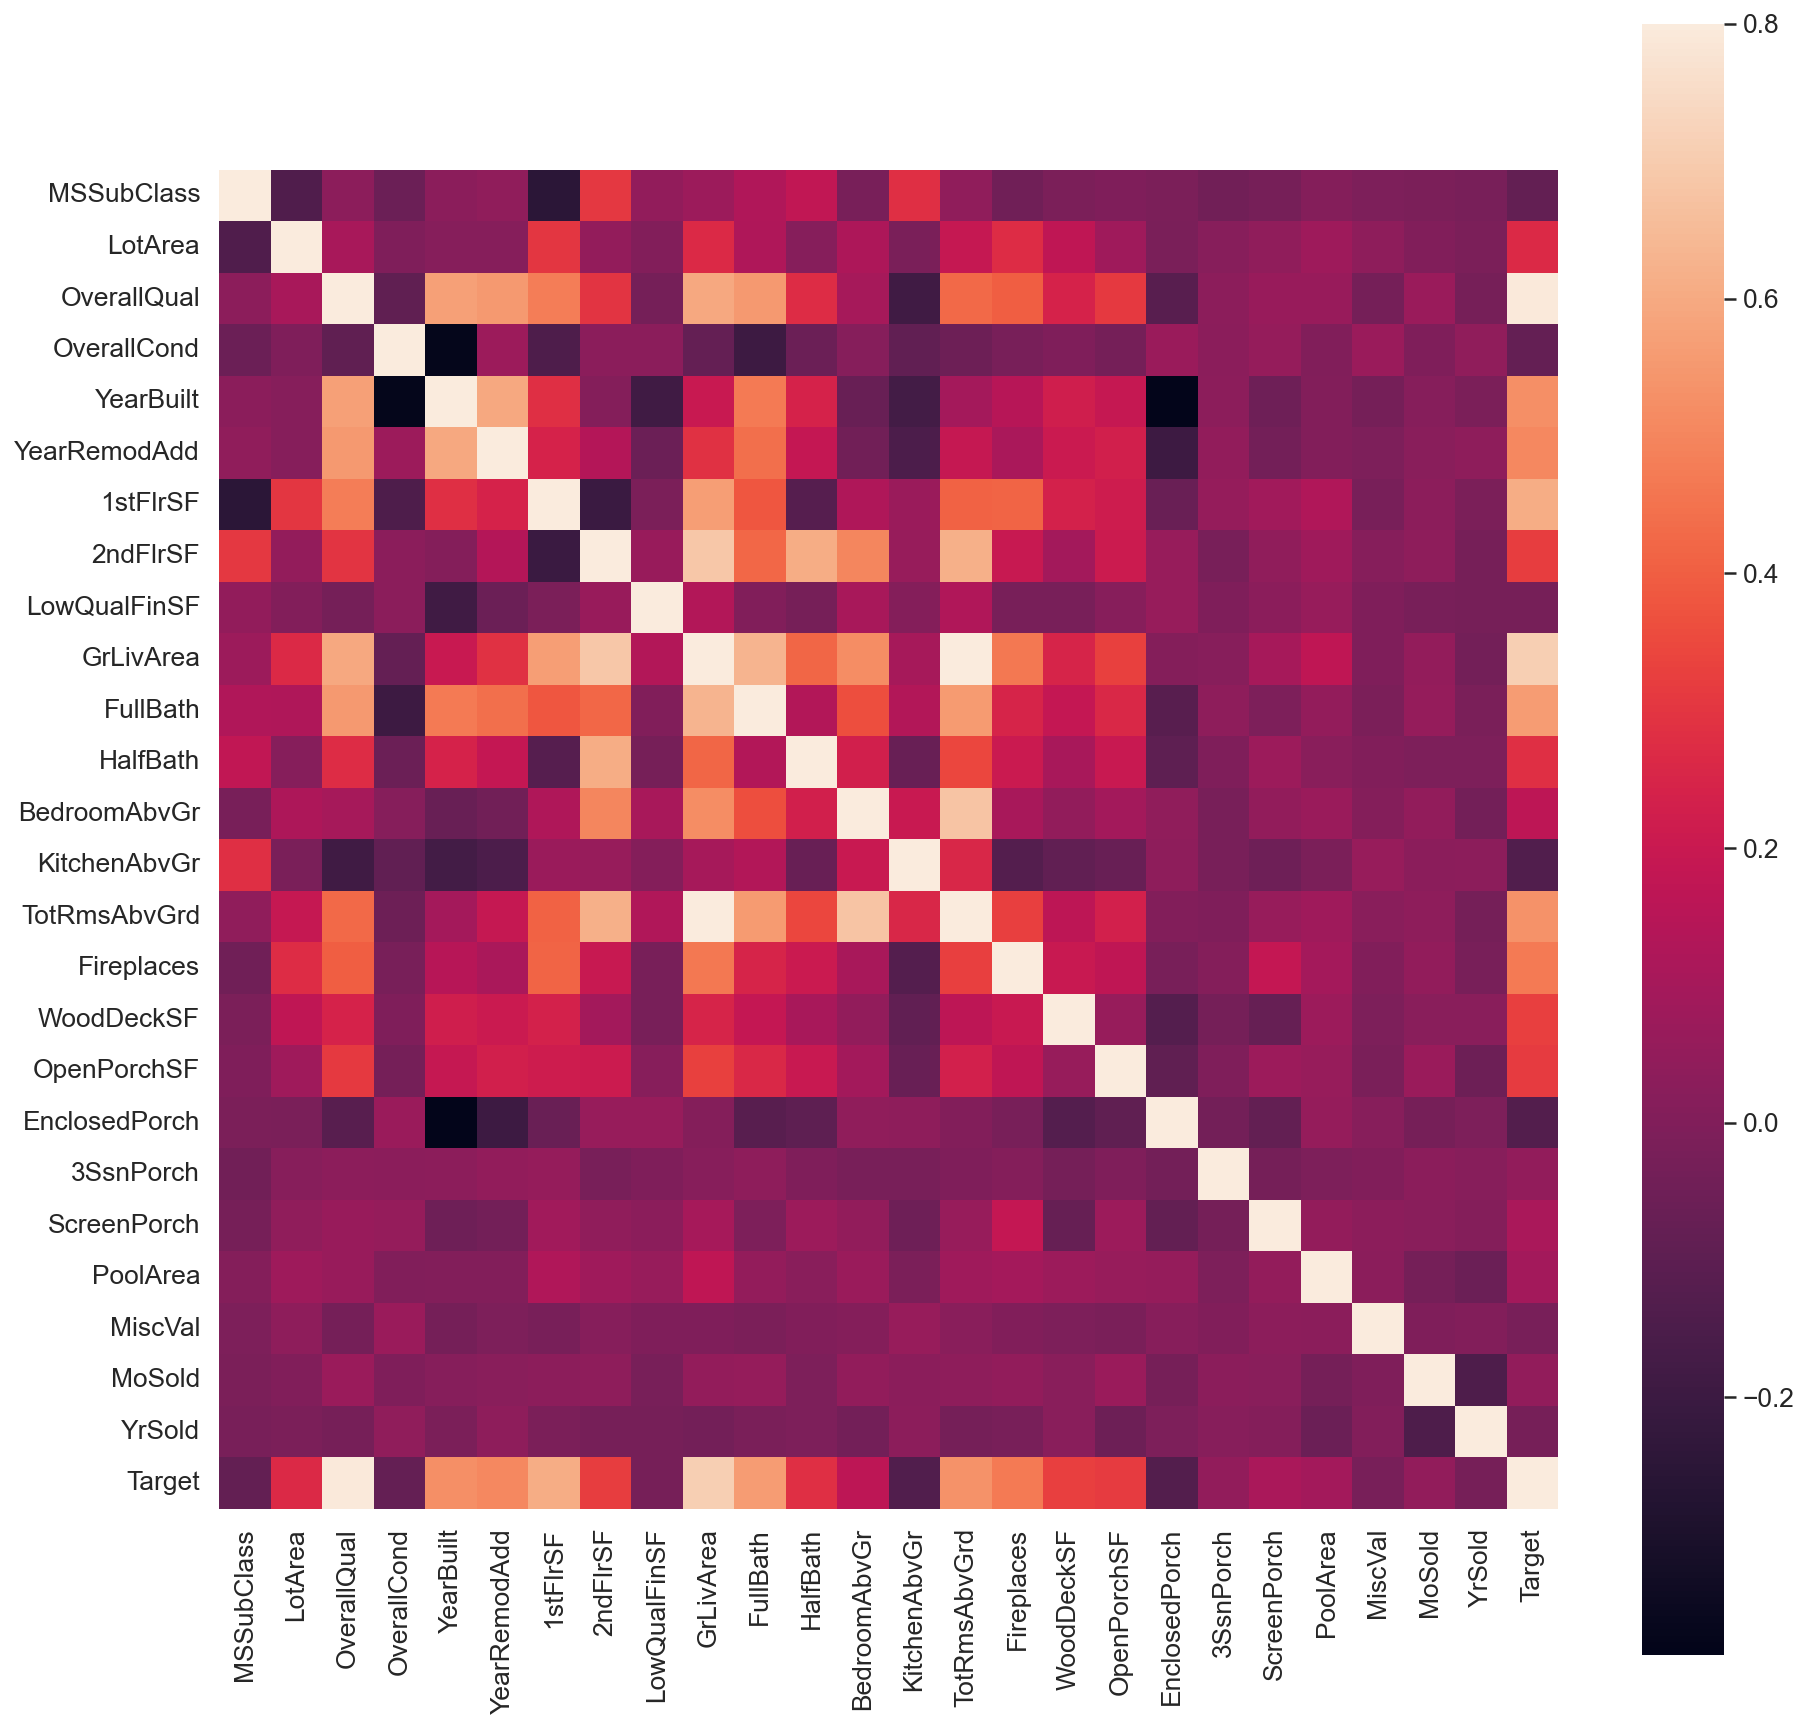

In [560]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target


C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [561]:
# One Hot Encoding of categorical data
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df


print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))


There were 79 columns before encoding categorical features
There are 183 columns after encoding categorical features


In [562]:
combined = combined[["OverallQual", "GrLivArea", "FullBath", "TotRmsAbvGrd", "YearBuilt", "1stFlrSF", "Fireplaces", "2ndFlrSF", "WoodDeckSF", "YearRemodAdd"]]

In [563]:
def split_combined():
    global combined
    train = combined[:1460]
    test = combined[1460:]

    return train , test

train, test = split_combined()


In [564]:
train = torch.from_numpy(train.to_numpy()).float()
test = torch.from_numpy(test.to_numpy()).float()
target = torch.squeeze(torch.from_numpy(target.to_numpy()).float())


#### Building Neural Network

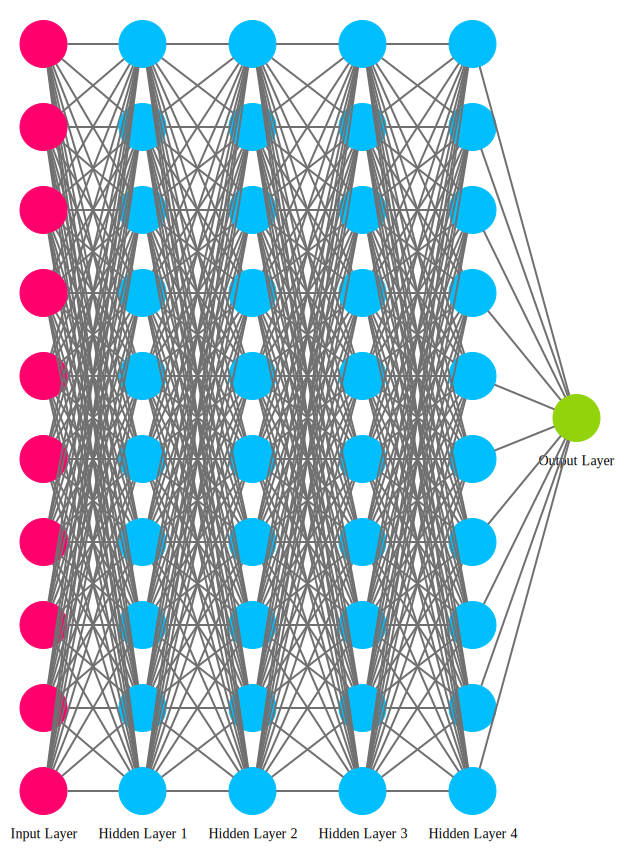

In [565]:
class NN(nn.Module):
    def __init__(self, n_features):
        super(NN, self).__init__()
        self.l1 = nn.Linear(n_features, 10)
        self.l2 = nn.Linear(10, 10)
        self.l3 = nn.Linear(10, 10)
        self.l4 = nn.Linear(10, 10)
        self.l5 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        x = self.l5(x)
        return x

Neural_Network = NN(train.shape[1])

ann_viz(Neural_Network, view=False)

#### Training

In [566]:
criterion = nn.L1Loss()

In [567]:
optimizer = optim.Adam(Neural_Network.parameters(), lr=0.001)

In [568]:
device = torch.device("cpu")

In [569]:
train_data = train.to(device)
test_data = test.to(device)

In [570]:
for epoch in range(1500):
    pred = Neural_Network(train_data)

    pred = torch.squeeze(pred)
    train_loss = criterion(pred, target)

    if epoch % 100 == 0:
        print(f"epoch {epoch}, train loss: {train_loss}")

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

epoch 0, train loss: 180924.625
epoch 100, train loss: 180554.34375
epoch 200, train loss: 157576.078125
epoch 300, train loss: 41687.95703125
epoch 400, train loss: 39310.359375
epoch 500, train loss: 36494.37109375
epoch 600, train loss: 34783.4296875
epoch 700, train loss: 34260.55859375
epoch 800, train loss: 34195.30859375
epoch 900, train loss: 34169.234375
epoch 1000, train loss: 34150.1953125
epoch 1100, train loss: 34132.26953125
epoch 1200, train loss: 34114.3515625
epoch 1300, train loss: 34095.58203125
epoch 1400, train loss: 34076.0234375


#### Saving model

In [571]:
MODEL_PATH = 'model.pth'

torch.save(Neural_Network, MODEL_PATH)

#### Test the model

In [576]:
def make_submission(prediction, sub_name):
  my_submission = pd.DataFrame({'Id':pd.read_csv('house-prices-advanced-regression-techniques/test.csv').Id,'SalePrice':prediction})
  my_submission.to_csv('{}.csv'.format(sub_name),index=False)
  print('A submission file has been made')

predictions = Neural_Network(test)
make_submission(predictions.detach().numpy()[:,0],'submission(NN)')

A submission file has been made
